## Class imbalance and depletion estimates from experimental data 

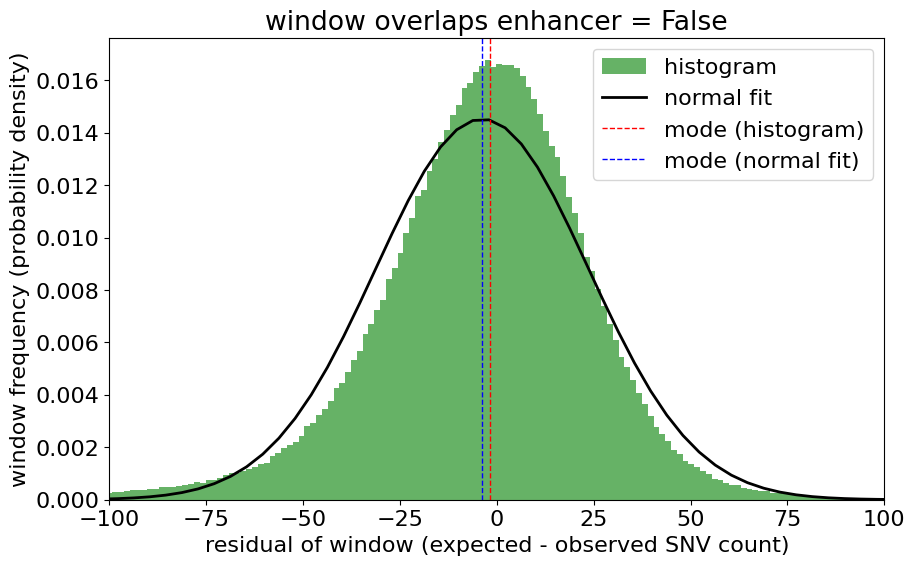

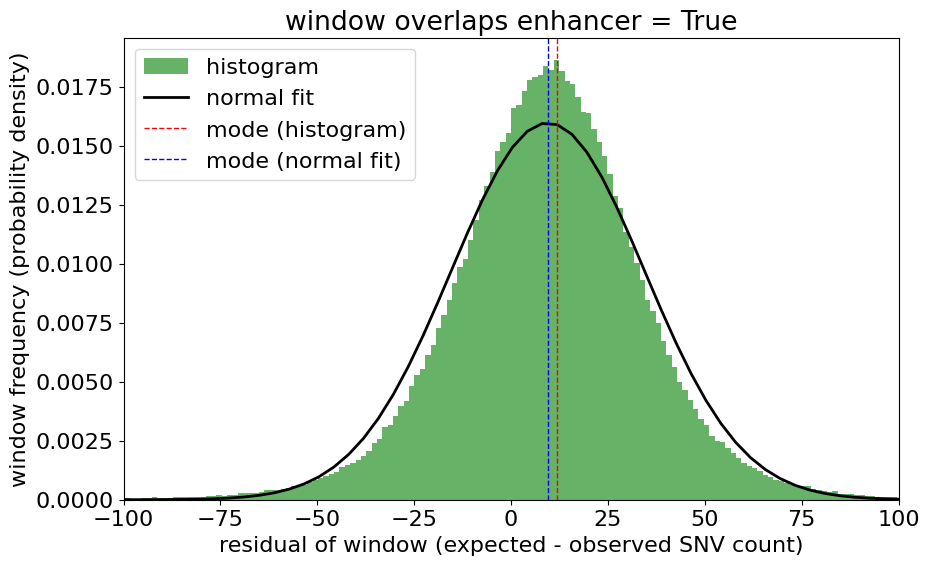

In [10]:
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools'

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm

plt.rcParams.update({'font.size': 16})

def get_noncoding_chen_windows(): 
    df = pl.read_csv(
        # non-exonic windows
        f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.features.constraint_scores.bed', 
        separator='\t',
    )
    df = df.to_pandas()
    return df 

def compute_number_records_in_each_class(df):
    ser = df['window overlaps enhancer'].value_counts()
    df = ser.to_frame().reset_index()
    df.columns = ['window overlaps enhancer', 'number of windows']
    return df

def plot_residual_distribution_experiment(df, window_overlaps_enhancer): 
    df_subset = df[df['window overlaps enhancer'] == window_overlaps_enhancer]

    # Compute histogram
    counts, bin_edges = np.histogram(df_subset['residual'], bins=1000)
    
    # Find the bin with the maximum count
    max_bin_index = np.argmax(counts)
    mode_histogram = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
    
    # Fit a normal distribution to the data
    mu, std = norm.fit(df_subset['residual'])
    
    # Compute the mode of the normal distribution
    mode_fit = mu  # For a normal distribution, the mode is the same as the mean

    plt.figure(figsize=(10, 6))

    # Plot histogram
    plt.hist(df_subset['residual'], bins=250, density=True, alpha=0.6, color='g', label='histogram')
    
    # Plot the normal distribution
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, mu, std) 
    plt.plot(x, p, 'k', linewidth=2, label='normal fit')
    
    # Plot vertical lines
    plt.axvline(mode_histogram, color='r', linestyle='dashed', linewidth=1, label='mode (histogram)')
    plt.axvline(mode_fit, color='b', linestyle='dashed', linewidth=1, label='mode (normal fit)')
    
    plt.title(f'window overlaps enhancer = {window_overlaps_enhancer}')
    plt.xlabel('residual of window (expected - observed SNV count)')
    plt.ylabel('window frequency (probability density)')

    plt.xlim(-100, 100)

    plt.legend()
    plt.show()

    return mode_histogram, mode_fit

def compute_depletion(df):
    df = pd.DataFrame({ 
        'window overlaps enhancer': df['window overlaps enhancer'],
        'residual': df['N_mean_null_gnocchi'] - df['N_observed'],
    })

    mode_histogram_unconstrained, mode_fit_unconstrained = plot_residual_distribution_experiment(df, window_overlaps_enhancer=False)
    mode_histogram_constrained, mode_fit_constrained = plot_residual_distribution_experiment(df, window_overlaps_enhancer=True)

    depletion_histogram = mode_histogram_constrained - mode_histogram_unconstrained
    depletion_fit = mode_fit_constrained - mode_fit_unconstrained

    depletion = pd.DataFrame({
        'depletion (estimated using histogram)': [depletion_histogram],
        'depletion (estimated using fit to histogram)': [depletion_fit],
    })

    depletion = depletion.T

    return depletion
    
def compute_class_imbalance_and_depletion():
    df = get_noncoding_chen_windows()  
    number_records_in_each_class = compute_number_records_in_each_class(df)  
    depletion = compute_depletion(df)
    return number_records_in_each_class, depletion

CLASS_IMBALANCE, DEPLETION = compute_class_imbalance_and_depletion()

In [11]:
CLASS_IMBALANCE

,window overlaps enhancer,number of windows
0,False,693270
1,True,309957


In [12]:
DEPLETION

,0
depletion (estimated using histogram),13.676763
depletion (estimated using fit to histogram),13.293118


In light of these experimental results, 
we will use a class imbalance of 7:3 (unconstrained:constrained) and a depletion of SNV counts due to (weak) purifying selection of about 15 in simulations, which we turn to next. 